<a href="https://colab.research.google.com/github/adityagupta0251/NASA_EXOPLANETS_DETECTION/blob/main/AstroCluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
arashnic_exoplanets_path = kagglehub.dataset_download('arashnic/exoplanets')

print('Data source import complete.')


100%|██████████| 1.03M/1.03M [00:00<00:00, 21.3MB/s]

Extracting files...


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import *
import lightgbm as lgb
import xgboost as xgb
# Sklearn Evaluation Metrics
from sklearn import metrics


# Visualizes all the columns
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):



    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

df = pd.read_csv('./input/exoplanets.csv')

# Print the shape of the dataset
print(df.shape)

# Select top of the dataset
df.head()

(9564, 49)


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.780000e-05,-2.780000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,616.0,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,35.8,1.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.480000e-04,-2.480000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,875.0,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,25.8,2.0,q1_q17_dr25_tce,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10800.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,76.3,1.0,q1_q17_dr25_tce,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8080.0,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,505.6,1.0,q1_q17_dr25_tce,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.0,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,40.9,1.0,q1_q17_dr25_tce,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [7]:
df = df.rename(columns={'kepid':'KepID',
'kepoi_name':'KOIName',
'kepler_name':'KeplerName',
'koi_disposition':'ExoplanetArchiveDisposition',
'koi_pdisposition':'DispositionUsingKeplerData',
'koi_score':'DispositionScore',
'koi_fpflag_nt':'NotTransit-LikeFalsePositiveFlag',
'koi_fpflag_ss':'koi_fpflag_ss',
'koi_fpflag_co':'CentroidOffsetFalsePositiveFlag',
'koi_fpflag_ec':'EphemerisMatchIndicatesContaminationFalsePositiveFlag',
'koi_period':'OrbitalPeriod_days',
'koi_period_err1':'OrbitalPeriodUpperUnc_days',
'koi_period_err2':'OrbitalPeriodLowerUnc_days',
'koi_time0bk':'TransitEpoch_BKJD',
'koi_time0bk_err1':'TransitEpochUpperUnc_BKJD',
'koi_time0bk_err2':'TransitEpochLowerUnc_BKJD',
'koi_impact':'ImpactParamete',
'koi_impact_err1':'ImpactParameterUpperUnc',
'koi_impact_err2':'ImpactParameterLowerUnc',
'koi_duration':'TransitDuration_hrs',
'koi_duration_err1':'TransitDurationUpperUnc_hrs',
'koi_duration_err2':'TransitDurationLowerUnc_hrs',
'koi_depth':'TransitDepth_ppm',
'koi_depth_err1':'TransitDepthUpperUnc_ppm',
'koi_depth_err2':'TransitDepthLowerUnc_ppm',
'koi_prad':'PlanetaryRadius_Earthradii',
'koi_prad_err1':'PlanetaryRadiusUpperUnc_Earthradii',
'koi_prad_err2':'PlanetaryRadiusLowerUnc_Earthradii',
'koi_teq':'EquilibriumTemperatureK',
'koi_teq_err1':'EquilibriumTemperatureUpperUncK',
'koi_teq_err2':'EquilibriumTemperatureLowerUncK',
'koi_insol':'InsolationFlux_Earthflux',
'koi_insol_err1':'InsolationFluxUpperUnc_Earthflux',
'koi_insol_err2':'InsolationFluxLowerUnc_Earthflux',
'koi_model_snr':'TransitSignal-to-Nois',
'koi_tce_plnt_num':'TCEPlanetNumbe',
'koi_tce_delivname':'TCEDeliver',
'koi_steff':'StellarEffectiveTemperatureK',
'koi_steff_err1':'StellarEffectiveTemperatureUpperUncK',
'koi_steff_err2':'StellarEffectiveTemperatureLowerUncK',
'koi_slogg':'StellarSurfaceGravity_log10(cm/s**2)',
'koi_slogg_err1':'StellarSurfaceGravityUpperUnc_log10(cm/s**2)',
'koi_slogg_err2':'StellarSurfaceGravityLowerUnc_log10(cm/s**2)',
'koi_srad':'StellarRadius_Solarradii',
'koi_srad_err1':'StellarRadiusUpperUnc_Solarradii',
'koi_srad_err2':'StellarRadiusLowerUnc_Solarradii',
'ra':'RA_decimaldegrees',
'dec':'Dec_decimaldegrees',
'koi_kepmag':'Kepler-band_mag'
})
df.head().T

,0,1,2,3,4
KepID,10797460,10797460,10811496,10848459,10854555
KOIName,K00752.01,K00752.02,K00753.01,K00754.01,K00755.01
KeplerName,Kepler-227 b,Kepler-227 c,NaN,NaN,Kepler-664 b
ExoplanetArchiveDisposition,CONFIRMED,CONFIRMED,CANDIDATE,FALSE POSITIVE,CONFIRMED
DispositionUsingKeplerData,CANDIDATE,CANDIDATE,CANDIDATE,FALSE POSITIVE,CANDIDATE
DispositionScore,1.0,0.969,0.0,0.0,1.0
NotTransit-LikeFalsePositiveFlag,0,0,0,0,0
koi_fpflag_ss,0,0,0,1,0
CentroidOffsetFalsePositiveFlag,0,0,0,0,0
EphemerisMatchIndicatesContaminationFalsePositiveFlag,0,0,0,0,0


In [9]:
df.isnull().sum()

,0
KepID,0
KOIName,0
KeplerName,7205
ExoplanetArchiveDisposition,0
DispositionUsingKeplerData,0
DispositionScore,1510
NotTransit-LikeFalsePositiveFlag,0
koi_fpflag_ss,0
CentroidOffsetFalsePositiveFlag,0
EphemerisMatchIndicatesContaminationFalsePositiveFlag,0


>Let’s choose the targets we want to predict: Exoplanet Archive Disposition and Disposition Using Kepler Data. Since we are focusing on data collected by the Kepler mission, let’s use our second option. We also need a continuous target. Let’s transform our target into a binary feature using lambda.

In [10]:
df['ExoplanetCandidate'] = df['DispositionUsingKeplerData'].apply(lambda x: 1 if x == 'CANDIDATE' else 0)
df['ExoplanetConfirmed'] = df['ExoplanetArchiveDisposition'].apply(lambda x: 2 if x == 'CONFIRMED' else 1 if x == 'CANDIDATE' else 0 )


<Axes: ylabel='count'>

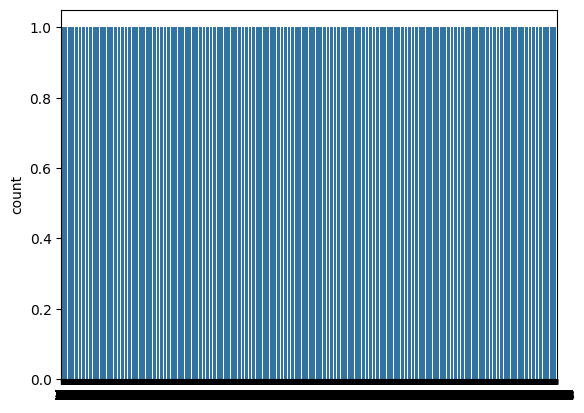

In [11]:
sns.countplot(df['ExoplanetCandidate'])

<Axes: ylabel='count'>

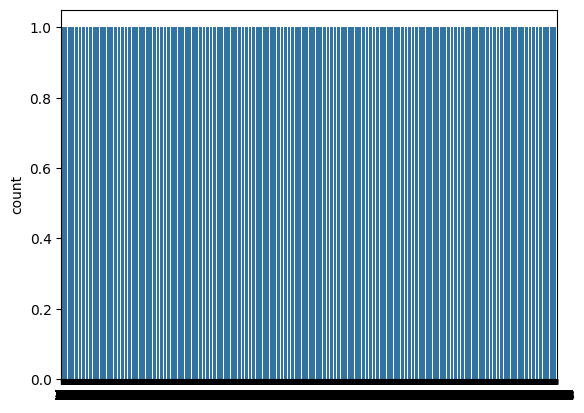

In [12]:
sns.countplot(df['ExoplanetConfirmed'])

In [13]:
df.drop(columns=['KeplerName','KOIName','EquilibriumTemperatureUpperUncK',
                 'KepID','ExoplanetArchiveDisposition','DispositionUsingKeplerData',
                 'NotTransit-LikeFalsePositiveFlag','koi_fpflag_ss','CentroidOffsetFalsePositiveFlag',
                 'EphemerisMatchIndicatesContaminationFalsePositiveFlag','TCEDeliver',
                 'EquilibriumTemperatureLowerUncK'], inplace=True)

In [14]:
df.dropna(inplace=True)
df.shape

(7803, 39)

(7803, 39)

In [27]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df = df.dropna()  # don't modify in place to avoid side effects
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)


(7803, 39)

In [29]:
train, test = train_test_split(df, test_size=.15)
data = df.drop(columns=['ExoplanetConfirmed'])
train = train.drop(columns=['ExoplanetConfirmed'])
test = test.drop(columns=['ExoplanetConfirmed'])
target_trn = train.pop('ExoplanetCandidate')
target_tst = test.pop('ExoplanetCandidate')


In [30]:
train.shape, target_trn.shape, test.shape, target_tst.shape

((6632, 37), (6632,), (1171, 37), (1171,))

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6632 entries, 3201 to 2246
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   DispositionScore                              6632 non-null   float64
 1   OrbitalPeriod_days                            6632 non-null   float64
 2   OrbitalPeriodUpperUnc_days                    6632 non-null   float64
 3   OrbitalPeriodLowerUnc_days                    6632 non-null   float64
 4   TransitEpoch_BKJD                             6632 non-null   float64
 5   TransitEpochUpperUnc_BKJD                     6632 non-null   float64
 6   TransitEpochLowerUnc_BKJD                     6632 non-null   float64
 7   ImpactParamete                                6632 non-null   float64
 8   ImpactParameterUpperUnc                       6632 non-null   float64
 9   ImpactParameterLowerUnc                       6632 non-null   flo

In [32]:
score_auc = []
score_recall = []
oof_rf = np.zeros(len(train))
pred_rf = np.zeros(len(test))

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target_trn)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target_trn.iloc[train_ind], target_trn.iloc[val_ind]

    rf = RandomForestClassifier(n_estimators=150, max_depth=5, criterion='gini', max_features=0.8, n_jobs= -1, random_state=32)
    rf.fit(trn_data, y_train)
    oof_rf[val_ind] = rf.predict_proba(val_data)[:, 1]
    y = rf.predict_proba(trn_data)[:, 1]
    print('val auc:' , roc_auc_score(y_val, oof_rf[val_ind]))
    print('val recall:' , recall_score(y_val, np.where(oof_rf[val_ind] > 0.5, 1, 0)))

    score_auc.append(roc_auc_score(y_val, oof_rf[val_ind]))
    score_recall.append(recall_score(y_val, np.where(oof_rf[val_ind] > 0.5, 1, 0)))

    pred_rf += rf.predict_proba(test)[:, 1]/folds.n_splits

print(' Model auc: -------> ', np.mean(score_auc))
print(' Model recall: -------> ', np.mean(score_recall))


fold: 0   - Starting ...
val auc: 0.9881264901801735
val recall: 0.9458987783595113
fold: 1   - Starting ...
val auc: 0.9846563490828055
val recall: 0.9301310043668122
fold: 2   - Starting ...
val auc: 0.9920319002808702
val recall: 0.9641921397379912
 Model auc: ------->  0.9882715798479498
 Model recall: ------->  0.9467406408214383


In [34]:
import pickle
with open("/content/random_forest_model.pkl", "wb") as f:
    pickle.dump(rf, f)

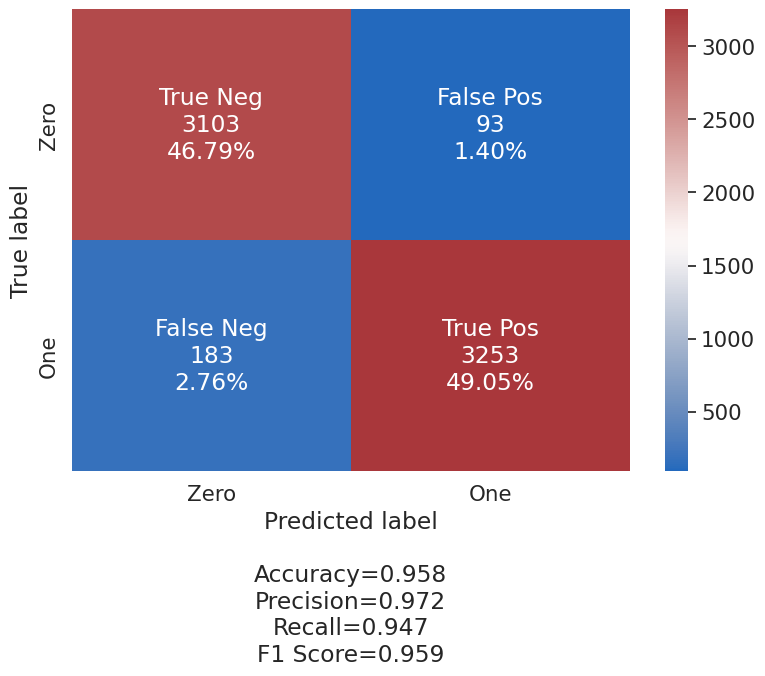

In [36]:
oof_nn_rd = np.where(oof_rf >= 0.5, 1, 0)
cf_matrix = confusion_matrix(target_trn, oof_nn_rd)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
# plt.style.use('seaborn-poster') # Removed invalid style
sns.set(font_scale=1.4)
make_confusion_matrix(cf_matrix,
                      group_names=labels,
                      categories=categories,
                      cmap='vlag', figsize=(9, 6))

In [37]:
roc_auc_score(target_tst, pred_rf)

np.float64(0.9857827476038338)

In [39]:
xgb_params = {

    'objective':'binary:logistic',
    'max_depth': 5,
    'learning_rate': 0.01,
    'booster':'gbtree',
    'eval_metric': 'auc',
    'max_leaves': 10,
    'colsample_bytree': 0.8, #feature fraction
    'subsample':0.7, # bagging fraction
    'lambda': 2,
    'alpha': 3,


}


xgb_scores = []

oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

importances = pd.DataFrame()


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4242)

for fold_, (train_ind, val_ind) in enumerate(folds.split(train, target_trn)):
    print('fold : ----------------------------------------', fold_)
    trn_data = xgb.DMatrix(data=train.iloc[train_ind], label=target_trn.iloc[train_ind])
    val_data = xgb.DMatrix(data= train.iloc[val_ind], label=target_trn.iloc[val_ind])


    xgb_model = xgb.train(xgb_params, trn_data, num_boost_round=1000, evals=[(trn_data, 'train'), (val_data, 'test')], verbose_eval=100, early_stopping_rounds=100)
    oof_xgb[val_ind] = xgb_model.predict(xgb.DMatrix(train.iloc[val_ind]),  iteration_range=(0, xgb_model.best_iteration))

    print(roc_auc_score(target_trn.iloc[val_ind], oof_xgb[val_ind]))
    xgb_scores.append(roc_auc_score(target_trn.iloc[val_ind], oof_xgb[val_ind]))

    importance_score = xgb_model.get_score(importance_type='gain')
    importance_frame = pd.DataFrame({'Importance': list(importance_score.values()), 'Feature': list(importance_score.keys())})
    importance_frame['fold'] = fold_ +1
    importances = pd.concat([importances, importance_frame], axis=0, sort=False)

    pred_xgb += xgb_model.predict(xgb.DMatrix(test), iteration_range=(0, xgb_model.best_iteration))/folds.n_splits

print('model auc:------------------>', np.mean(xgb_scores))

fold : ---------------------------------------- 0
[0]	train-auc:0.97454	test-auc:0.97331
[100]	train-auc:0.98955	test-auc:0.98731
[200]	train-auc:0.99100	test-auc:0.98823
[300]	train-auc:0.99224	test-auc:0.98954
[400]	train-auc:0.99327	test-auc:0.98987
[500]	train-auc:0.99415	test-auc:0.99014
[600]	train-auc:0.99482	test-auc:0.99041
[700]	train-auc:0.99539	test-auc:0.99064
[800]	train-auc:0.99584	test-auc:0.99079
[900]	train-auc:0.99625	test-auc:0.99086
[999]	train-auc:0.99663	test-auc:0.99098
0.9909901917967755
fold : ---------------------------------------- 1
[0]	train-auc:0.97793	test-auc:0.97391
[100]	train-auc:0.98954	test-auc:0.98707
[153]	train-auc:0.99042	test-auc:0.98725
0.9873078147743812
fold : ---------------------------------------- 2
[0]	train-auc:0.97787	test-auc:0.97266
[100]	train-auc:0.99022	test-auc:0.98562
[200]	train-auc:0.99147	test-auc:0.98607
[300]	train-auc:0.99277	test-auc:0.98723
[400]	train-auc:0.99371	test-auc:0.98831
[500]	train-auc:0.99448	test-auc:0.9888

In [40]:
import pickle
with open("/content/xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

In [41]:
roc_auc_score(target_tst, pred_xgb)

np.float64(0.9888032359234399)

<Axes: xlabel='Importance', ylabel='Feature'>

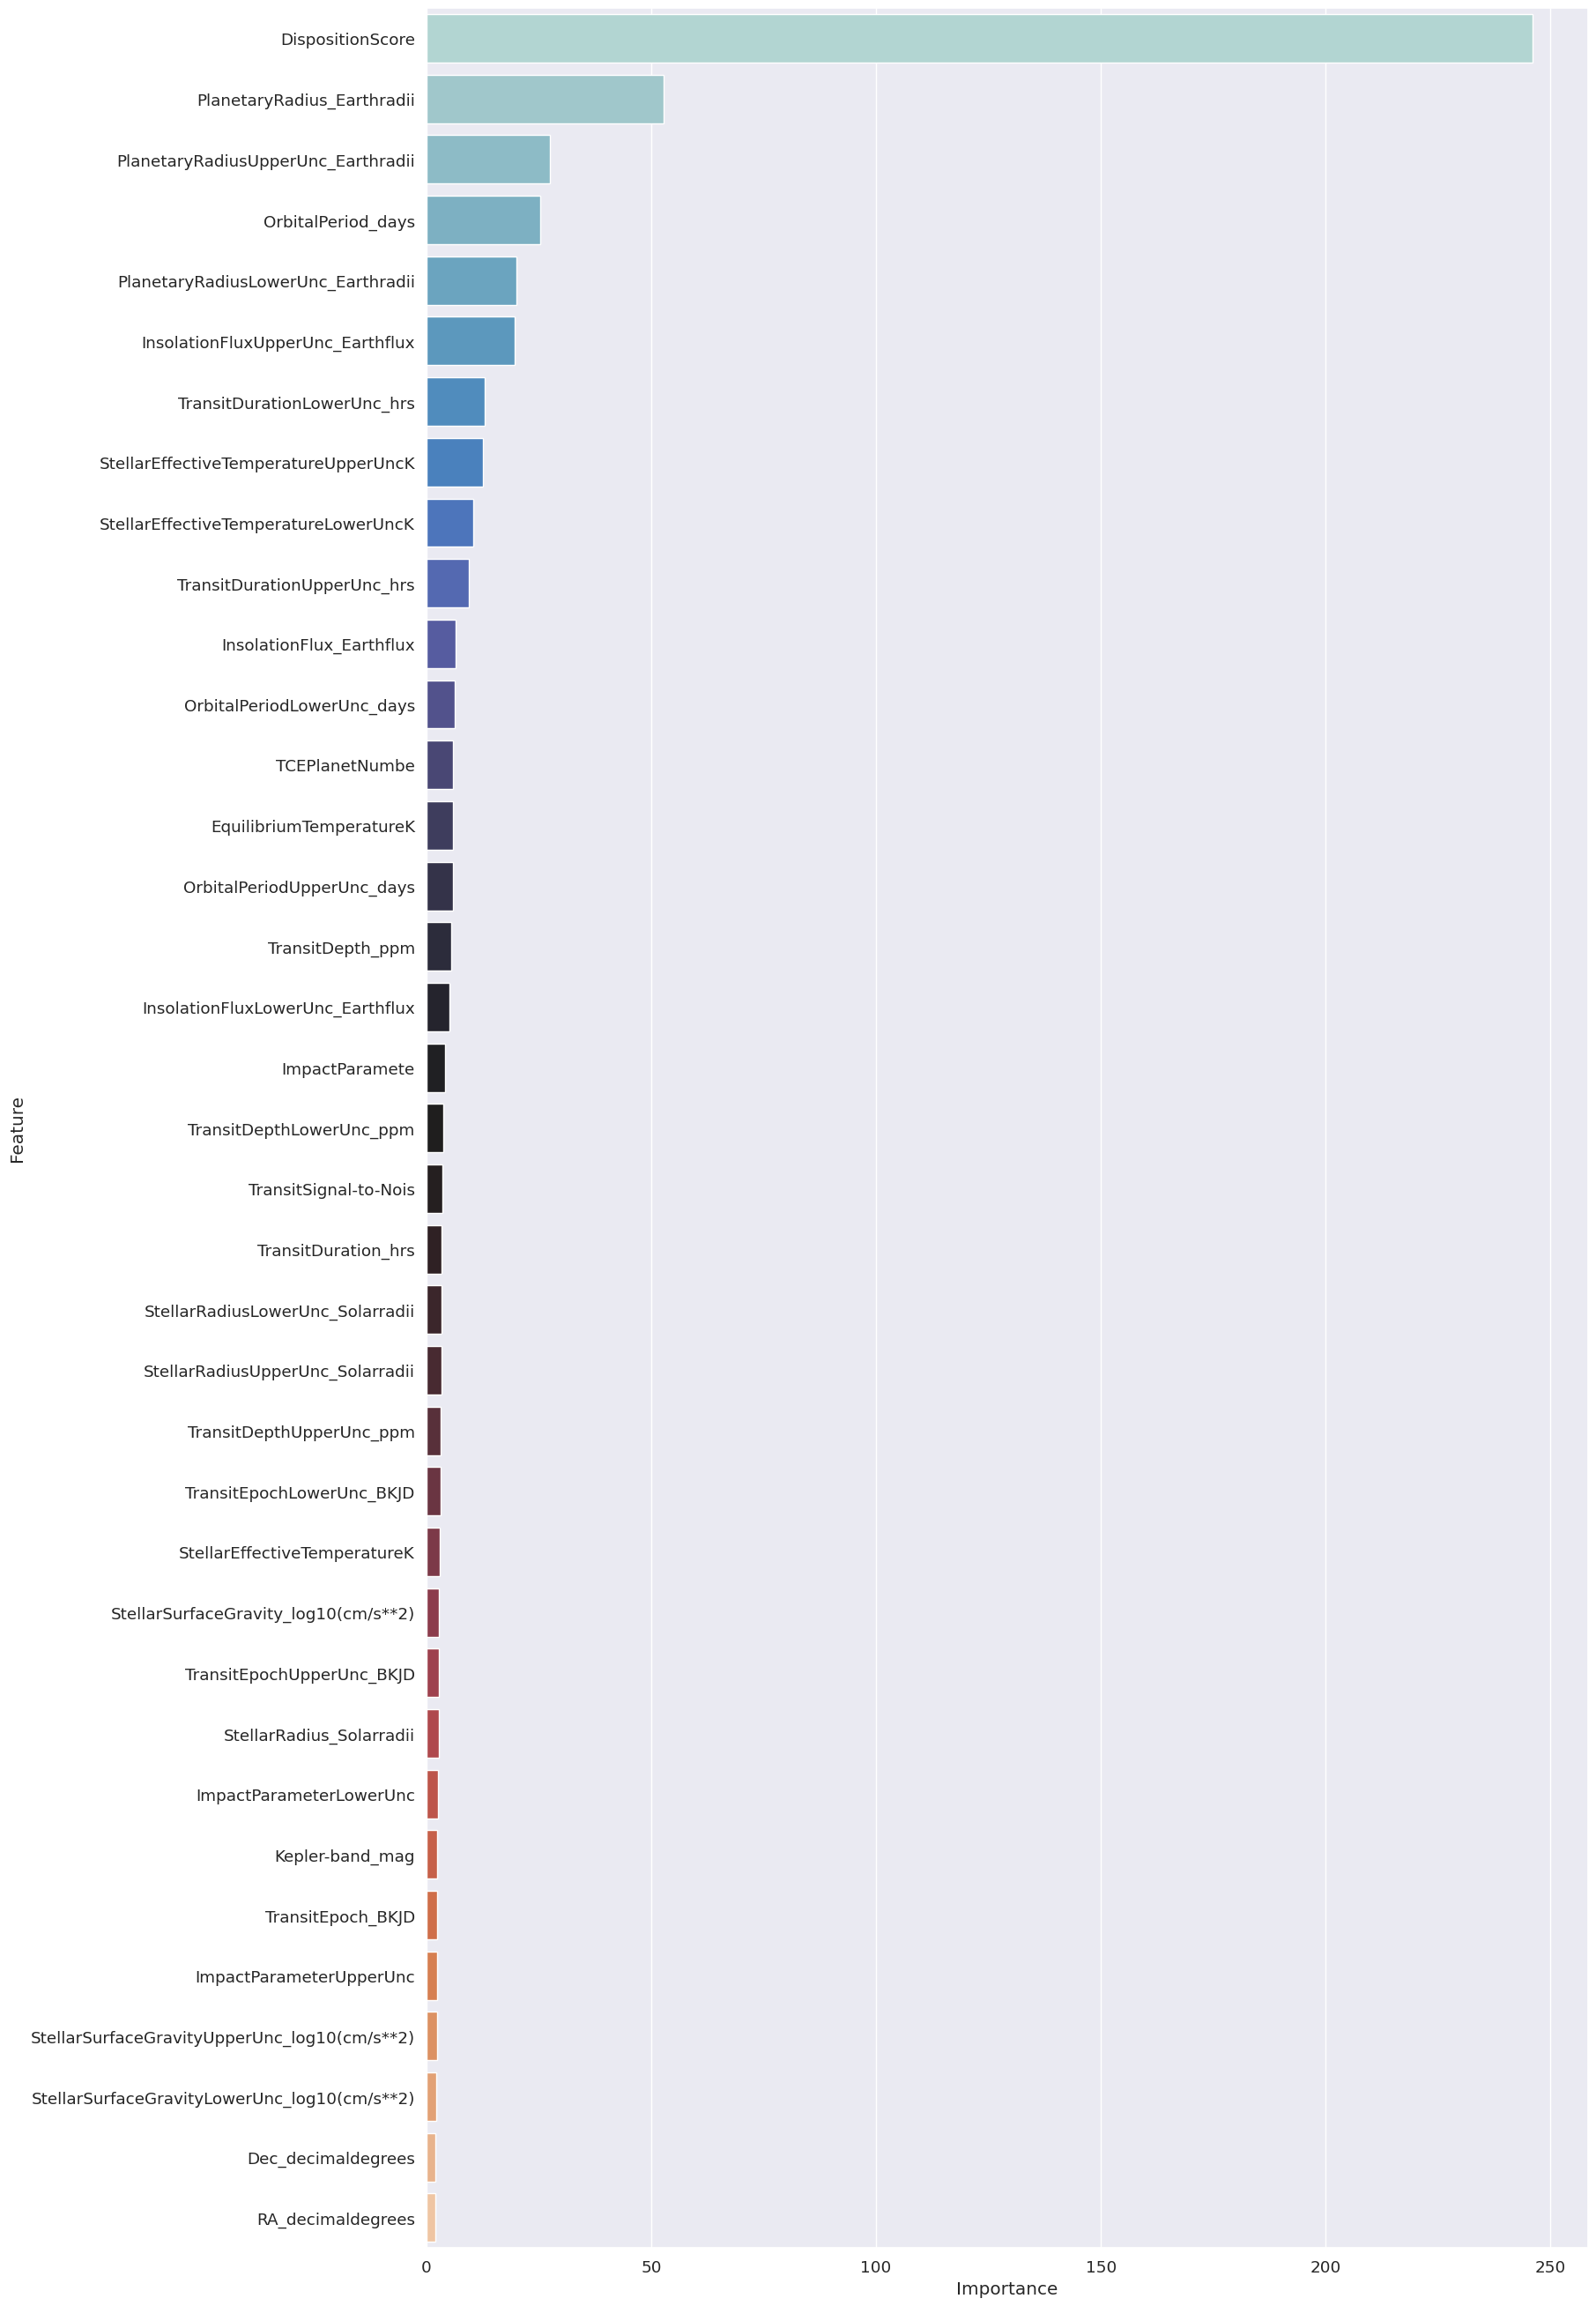

In [42]:
mean_gain = importances[['Importance', 'Feature']].groupby('Feature').mean()
#importances['mean_score'] = importances['Feature'].map(mean_gain['Importance'])
mean_gain = mean_gain.reset_index()
sns.set(font_scale=1.2)
plt.figure(figsize=(17, 33))
sns.barplot(x='Importance', y='Feature', data=mean_gain.sort_values('Importance', ascending=False), palette='icefire')

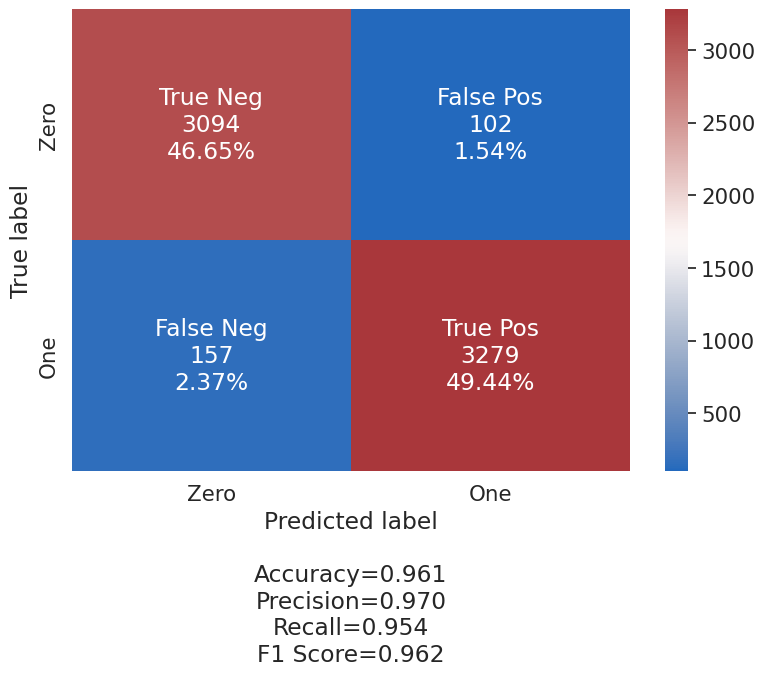

In [44]:
oof_nn_rd = np.where(oof_xgb >= 0.5, 1, 0)
cf_matrix = confusion_matrix(target_trn, oof_nn_rd)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
# plt.style.use('seaborn-poster') # Removed invalid style
sns.set(font_scale=1.4)
make_confusion_matrix(cf_matrix,
                      group_names=labels,
                      categories=categories,
                      cmap='vlag', figsize=(9, 6))

In [46]:
from sklearn.linear_model import LogisticRegression
score_auc = []
score_recall = []
oof_lr = np.zeros(len(train))
pred_lr = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_ , (train_ind, val_ind) in enumerate(folds.split(train, target_trn)):
    print('fold:', fold_, '  - Starting ...')
    trn_data, val_data = train.iloc[train_ind], train.iloc[val_ind]
    y_train, y_val = target_trn.iloc[train_ind], target_trn.iloc[val_ind]

    lr = LogisticRegression(C=1, max_iter=400, class_weight='balanced', random_state=32)
    lr.fit(trn_data, y_train)
    oof_lr[val_ind] = rf.predict_proba(val_data)[:, 1]
    y = lr.predict_proba(trn_data)[:, 1]
    print('val auc:' , roc_auc_score(y_val, oof_lr[val_ind]))
    print('val recall:' , recall_score(y_val, np.where(oof_lr[val_ind] >= 0.5, 1, 0)))

    score_auc.append(roc_auc_score(y_val, oof_lr[val_ind]))
    score_recall.append(recall_score(y_val, np.where(oof_lr[val_ind] >= 0.5, 1, 0)))

    pred_lr += lr.predict_proba(test)[:, 1]/folds.n_splits

print(' Model auc: -------> ', np.mean(score_auc))
print(' Model recall: -------> ', np.mean(score_recall))


fold: 0   - Starting ...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


val auc: 0.9961581504531062
val recall: 0.9563953488372093
fold: 1   - Starting ...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


val auc: 0.9949940866084426
val recall: 0.9548762736535662
fold: 2   - Starting ...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


val auc: 0.993609237504926
val recall: 0.9606986899563319
fold: 3   - Starting ...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


val auc: 0.9938973969972187
val recall: 0.9592430858806404
fold: 4   - Starting ...
val auc: 0.9912094270295881
val recall: 0.9650655021834061
 Model auc: ------->  0.9939736597186564
 Model recall: ------->  0.9592557801022308


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
import pickle
with open("/content/logistic_model.pkl", "wb") as f:
    pickle.dump(lr, f)